In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Usa Mersenne Twister com seed 42 para reprodutibilidade
np.random.seed(42)

In [2]:
# ----------------------------- System Parameters -------------------------
Num_users = 4  # Number of users
TX_ant = 64  # Number of UPA TX antennas
TX_ant_w = int(np.sqrt(TX_ant))  # width
TX_ant_h = int(np.sqrt(TX_ant))  # height
ind_TX_w = np.reshape(np.tile(np.arange(TX_ant_w), (TX_ant_h, 1)), (1, TX_ant_w * TX_ant_h))
ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)

RX_ant = 4  # Number of UPA RX antennas
RX_ant_w = int(np.sqrt(RX_ant))  # width
RX_ant_h = int(np.sqrt(RX_ant))  # height
ind_RX_w = np.reshape(np.tile(np.arange(RX_ant_w), (RX_ant_h, 1)), (1, RX_ant_w * RX_ant_h))
ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

In [3]:
# ----------------------------- Channel Parameters ------------------------
Num_paths = 10  # Number of channel paths

In [4]:
# ----------------------------- Simulation Parameters ---------------------
SNR_dB_range = np.arange(-10, 25, 5)  # SNR in dB
Rate_SU = np.zeros(len(SNR_dB_range))
Rate_BS = np.zeros(len(SNR_dB_range))
Rate_HP = np.zeros(len(SNR_dB_range))
Rate_HP_MSE = np.zeros(len(SNR_dB_range))
Rate_HP_Kalman = np.zeros(len(SNR_dB_range))
Rate_HP_FD_ZF = np.zeros(len(SNR_dB_range))
Rate_HP_FD_MSE = np.zeros(len(SNR_dB_range))

In [5]:
# Número de usuários
Num_users = 4

# Número de antenas na UPA do transmissor
TX_ant = 64
TX_ant_w = int(np.sqrt(TX_ant))  # Largura
TX_ant_h = int(np.sqrt(TX_ant))  # Altura

# Índices das antenas no grid da UPA
ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)

# Número de antenas na UPA do receptor
RX_ant = 4
RX_ant_w = int(np.sqrt(RX_ant))
RX_ant_h = int(np.sqrt(RX_ant))
ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)



ITER = 500

In [6]:
# Simulação
for iter in range(ITER):

    # Inicializa matrizes
    H = np.zeros((Num_users, RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
    a_TX = np.zeros((TX_ant_w * TX_ant_h, Num_users), dtype=complex)
    a_RX = np.zeros((RX_ant_w * RX_ant_h, Num_users), dtype=complex)

    ind_TX_w = np.repeat(np.arange(TX_ant_w), TX_ant_h)
    ind_TX_h = np.tile(np.arange(TX_ant_h), TX_ant_w)

    ind_RX_w = np.repeat(np.arange(RX_ant_w), RX_ant_h)
    ind_RX_h = np.tile(np.arange(RX_ant_h), RX_ant_w)

    AoD_el = np.zeros((Num_users, Num_paths), dtype=complex)
    AoD_az = np.zeros((Num_users, Num_paths), dtype=complex)
    AoA_el = np.zeros((Num_users, Num_paths), dtype=complex)
    AoA_az = np.zeros((Num_users, Num_paths), dtype=complex)
    alpha = np.zeros((Num_users, Num_paths), dtype=complex)

    # Construção dos canais
    for u in range(Num_users):
        AoD_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
        AoD_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)
        AoA_el[u, :] = np.pi * np.random.rand(1, Num_paths) - np.pi / 2
        AoA_az[u, :] = 2 * np.pi * np.random.rand(1, Num_paths)
        parte_real = norm.ppf(np.random.rand(1, Num_paths))
        parte_imag = 1j * (norm.ppf(np.random.rand(1, Num_paths)))
        alpha[u, :] = np.sqrt(1 / Num_paths) * (parte_real + parte_imag)

        Temp_Channel = np.zeros((RX_ant_w * RX_ant_h, TX_ant_w * TX_ant_h), dtype=complex)
        for l in range(Num_paths):
            parte1 = 1 / (TX_ant_w * TX_ant_h)
            parte2 = ind_TX_w * np.sin(AoD_az[u, l]) * np.sin(AoD_el[u, l])
            parte3 = ind_TX_h * np.cos(AoD_el[u, l])
            parte4 = np.exp(1j * np.pi * (parte2 + parte3))
            a_TX[:, u] = (np.sqrt(parte1) * parte4).flatten(order='F')  # 'F' mantém a ordem do MATLAB
            parte5 = 1 / (RX_ant_w * RX_ant_h)
            parte6 = ind_RX_w * np.sin(AoA_az[u, l]) * np.sin(AoA_el[u, l])
            parte7 = ind_RX_h * np.cos(AoA_el[u, l])
            parte8 = np.exp(1j * np.pi * (parte6 + parte7))
            a_RX[:, u] = (np.sqrt(parte5) * parte8).flatten(order='F')  # 'F' mantém a ordem do MATLAB
            parte9 = (TX_ant_w * TX_ant_h) * (RX_ant_w * RX_ant_h)
            parte10 = alpha[u, l] * a_RX[:, u]
            Temp_Channel += np.sqrt(parte9) * np.outer(parte10, a_TX[:, u].conj())  # Produto externo correto
        H[u, :, :] = Temp_Channel
    ####################################################################################################################
    # Stage 1 of the proposed algorithm (Analog precoding)
    Frf = np.zeros((TX_ant, Num_users), dtype=complex)
    Wrf = np.zeros((RX_ant, Num_users), dtype=complex)
    for u in range(Num_users):
        Frf[:, u] = a_TX[:, u]
        Wrf[:, u] = a_RX[:, u]
    ####################################################################################################################
    # Constructin the effective channels
    He = np.zeros((Num_users, RX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He[u, :] = Wrf[:, u].conj().T @ Channel @ Frf  # Cálculo do canal efetivo
    ####################################################################################################################
    # effective channel for fully digital precoding
    He_fd = np.zeros((Num_users, TX_ant), dtype=complex)
    for u in range(Num_users):
        Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
        Channel[:, :] = H[u, :, :]  # Extraindo a matriz H do usuário u
        He_fd[u, :] = Wrf[:, u].conj().T @ Channel  # Cálculo do canal efetivo
    ####################################################################################################################
    # Baseband Zero-Forcing Precoding (ZFBF)
    Fbb = He.conj().T @ (np.linalg.inv(He @ He.conj().T))
    # Normalização dos precodificadores híbridos
    for u in range(Num_users):
        norm_factor = np.sqrt((Frf @ Fbb[:, u]).conj().T @ (Frf @ Fbb[:, u]))
        if norm_factor != 0:  # Evitar divisão por zero
            Fbb[:, u] /= norm_factor  # Normalização
    ####################################################################################################################
    # =====================================================
    # Fully-Digital Zero-Forcing Precoding (ZFBF)
    # =====================================================
    # Ffd = He_fd' * pinv(He_fd * He_fd')
    Ffd = He_fd.conj().T @ np.linalg.pinv(He_fd @ He_fd.conj().T)
    # Normalização dos precodificadores
    for u in range(Num_users):
        norm_factor = np.linalg.norm(Ffd[:, u])  # Correta normalização da coluna
        if norm_factor != 0:  # Evitar divisão por zero
            Ffd[:, u] /= norm_factor
    ####################################################################################################################
    count_i = 0
    for count, SNR_dB_i in enumerate(SNR_dB_range, start=1):
        count_i = count_i + 1
        SNR = 10 ** (0.1 * SNR_dB_i) / Num_users  # Converter dB para valor linear
        sigma2 = 1 / SNR  # Variância do ruído
        ################################################################################################################
        # =====================================================
        # MMSE Baseband Precoder
        # =====================================================
        FbbMSE = np.linalg.inv(He.conj().T @ He + Num_users * sigma2 * Frf.conj().T @ Frf) @ He.conj().T
        # Normalização dos precodificadores híbridos
        for u in range(Num_users):
            norm_factor = np.linalg.norm(Frf @ FbbMSE[:, u])
            if norm_factor != 0:  # Evitar divisão por zero
                FbbMSE[:, u] /= norm_factor
        ################################################################################################################
        # =====================================================
        # Fully-Digital MMSE Precoding
        # =====================================================
        # FfdMSE = inv(He_fd'*He_fd + Num_users*sigma2*eye(TX_ant)) * He_fd'
        FfdMSE = np.linalg.inv(He_fd.conj().T @ He_fd + Num_users * sigma2 * np.eye(TX_ant)) @ He_fd.conj().T
        # Normalização dos precodificadores
        for u in range(Num_users):
            norm_factor = np.linalg.norm(FfdMSE[:, u])  # Correta normalização da coluna
            if norm_factor != 0:  # Evitar divisão por zero
                FfdMSE[:, u] /= norm_factor
        ################################################################################################################
        # =====================================================
        # Kalman Baseband Precoder
        # =====================================================
        Fbbk = np.eye(Num_users, Num_users, dtype=complex)
        RN1 = Fbbk @ Fbbk.conj().T
        Qm = np.eye(Num_users) * sigma2
        # Number of Kalman iterations
        ITERK=10
        for ii in range(ITERK):
             Hk = He
             K = RN1 @ Hk.conj().T @ np.linalg.pinv(Hk @ RN1 @ Hk.conj().T + Qm)  # Ganho de Kalman
             errk = np.eye(Num_users) - Hk @ Fbbk
             # errk = errk / np.linalg.norm(errk)
             errk /= np.linalg.norm(errk, 2)  # Normalização do erro
             Fbbk = Fbbk + K @ errk  # Atualização do precodificador
             RN = RN1 - K @ Hk @ RN1
             RN1 = RN
        # Normalização dos precodificadores híbridos
        for u in range(Num_users):
            norm_factor = np.linalg.norm(Frf @ Fbbk[:, u])  # Normalização correta
            if norm_factor != 0:  # Evitar divisão por zero
                Fbbk[:, u] /= norm_factor
        ################################################################################################################
        # Inicializando as variáveis de taxa de dados


        # Loop sobre os usuários
        for u in range(Num_users):
            Int_set = [i for i in range(Num_users) if i != u]  # Índices de interferência

            # Extraindo a matriz de canal do usuário u
            Channel = np.zeros((RX_ant, TX_ant), dtype=complex)
            Channel[:, :] = H[u, :, :]

            # Decomposição SVD
            U_channel, S_diag, V_channel = np.linalg.svd(Channel)

            # Expandir S_channel para uma matriz do mesmo tamanho do MATLAB (4x64)
            S_channel = np.zeros((U_channel.shape[0], V_channel.shape[0]))  # (4x64)
            np.fill_diagonal(S_channel, S_diag)  # Preenche a diagonal com os valores singulares
            # ------------------------------------------------------------
            # Taxa para o caso Single-User (SU)
            # Single-user rate
            Rate_SU[count_i - 1] += np.log2(1 + SNR * S_channel[0, 0] ** 2) / (Num_users * ITER)
            # ------------------------------------------------------------
            # Beamforming apenas analógico (Analog-only beamforming)
            numerador = SNR * (np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, u]) ** 2)
            denominador = SNR * np.sum(np.abs(Wrf[:, u].conj().T @ Channel @ Frf[:, Int_set]) ** 2) + 1
            SINR_BS = numerador / denominador
            # Atualiza a taxa do beamforming analógico
            Rate_BS[count_i - 1] += np.log2(1 + SINR_BS) / (Num_users * ITER)
        ################################################################################################################
        # Hybrid Precoding
        Rate_HP[count_i - 1] += np.log2(np.linalg.det((np.eye(Num_users)) +
                                                      SNR * (He @ (Fbb @ Fbb.conj().T) @ He.conj().T))) / (Num_users * ITER)
        ################################################################################################################
        # Hybrid Precoding MMSE
        Rate_HP_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                          SNR * (He @ (FbbMSE @ FbbMSE.conj().T) @ He.conj().T))) / (Num_users * ITER)
        ################################################################################################################
        # Hybrid Precoding Kalman
        Rate_HP_Kalman[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                             SNR * (He @ (Fbbk @ Fbbk.conj().T) @ He.conj().T))) / (Num_users * ITER)
        ################################################################################################################
        # ZF fully digital precoding
        Rate_HP_FD_ZF[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                            SNR * (He_fd @ (Ffd @ Ffd.conj().T) @ He_fd.conj().T))) / (Num_users * ITER)
        ################################################################################################################
        # MSE fully digital precoding
        Rate_HP_FD_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
                                                             SNR * (He_fd @ (FfdMSE @ FfdMSE.conj().T) @ He_fd.conj().T))) / (Num_users * ITER)

C:\Users\filipe.rodrigues\AppData\Local\Temp\ipykernel_6868\1383784030.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP[count_i - 1] += np.log2(np.linalg.det((np.eye(Num_users)) +
C:\Users\filipe.rodrigues\AppData\Local\Temp\ipykernel_6868\1383784030.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP_MSE[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
C:\Users\filipe.rodrigues\AppData\Local\Temp\ipykernel_6868\1383784030.py:176: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP_Kalman[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
C:\Users\filipe.rodrigues\AppData\Local\Temp\ipykernel_6868\1383784030.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  Rate_HP_FD_ZF[count_i - 1] += np.log2(np.linalg.det(np.eye(Num_users) +
C:\Users\filipe.rodrigues\AppData\Local\Temp\ipykernel_6868\1383784030.py:184: ComplexWarning

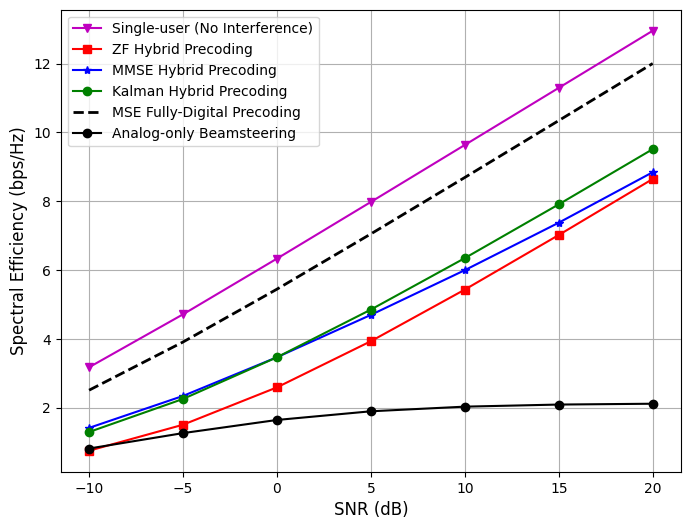

In [7]:
# Plotando a eficiência espectral
plt.figure(figsize=(8, 6))
plt.plot(SNR_dB_range, Rate_SU, '-mv', linewidth=1.5, label="Single-user (No Interference)")
plt.plot(SNR_dB_range, Rate_HP, '-rs', linewidth=1.5, label="ZF Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_MSE, '-b*', linewidth=1.5, label="MMSE Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_Kalman, '-go', linewidth=1.5, label="Kalman Hybrid Precoding")
plt.plot(SNR_dB_range, Rate_HP_FD_MSE, '--k', linewidth=2, label="MSE Fully-Digital Precoding")

# Verificando a condição para o número de caminhos
if Num_paths == 1:
    plt.plot(SNR_dB_range, Rate_BS, '-ro', linewidth=1.5, label="Analog-only Beamsteering")
else:
    plt.plot(SNR_dB_range, Rate_BS, '-ko', linewidth=1.5, label="Analog-only Beamsteering")

# Configurações do gráfico
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Spectral Efficiency (bps/Hz)', fontsize=12)
plt.legend()
plt.grid()
plt.show()